In [23]:
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import utils
%matplotlib inline

In [2]:
sqlContext = SQLContext(sc)
df = sqlContext.read.load('file:/home/cloudera/epri/minute_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [3]:
df.count()

1587257

In [4]:
filteredDF = df.filter((df.rowID % 100) == 0)
filteredDF.count()

15873

In [5]:
filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,15873,793600.0,458228.4746717515,0,1587200
air_pressure,15873,916.8291627291587,3.0517222151797943,905.1,929.4
air_temp,15873,61.854689094688936,11.83541379082148,32.36,96.44
avg_wind_direction,15870,161.2875236294896,95.3131612965649,0.0,359.0
avg_wind_speed,15870,2.7928040327662296,2.0705061984600173,0.1,20.1
max_wind_direction,15870,162.70094517958412,92.26960112663167,0.0,359.0
max_wind_speed,15870,3.41462507876495,2.428906406812135,0.1,20.9
min_wind_direction,15870,166.64429741650915,97.82483630682509,0.0,359.0
min_wind_speed,15870,2.1522684310018896,1.7581135042599596,0.0,19.5


In [6]:
#filteredDF.filter(filteredDF.rain_accumulation == 0.0).count() 

In [7]:
#workingDF = filteredDF.drop('rain_accumulation').drop('rain_duration').drop('hpwren_timestamp')

In [8]:
workingDF = filteredDF.na.drop()

In [9]:
workingDF.columns

['rowID',
 'hpwren_timestamp',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'rain_accumulation',
 'rain_duration',
 'relative_humidity']

In [10]:
featuresUsed = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDF)

In [11]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [12]:
scaledData = scaledData.select("features", "rowID")

elbowset = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowset.persist()

DataFrame[features: vector]

In [13]:
clusters = range(5,20)
wsseList = utils.elbow(elbowset, clusters)

Training for cluster size 5 
......................WSSE = 8804.118354684928 
Training for cluster size 6 
......................WSSE = 8525.400895523859 
Training for cluster size 7 
......................WSSE = 8123.225352699479 
Training for cluster size 8 
......................WSSE = 7876.960906428347 
Training for cluster size 9 
......................WSSE = 7887.3819888393555 
Training for cluster size 10 
......................WSSE = 7554.953661841033 
Training for cluster size 11 
......................WSSE = 7294.206903885911 
Training for cluster size 12 
......................WSSE = 7147.35701329177 
Training for cluster size 13 
......................WSSE = 7021.252055113944 
Training for cluster size 14 
......................WSSE = 6816.393499652169 
Training for cluster size 15 
......................WSSE = 6684.554579105646 
Training for cluster size 16 
......................WSSE = 6608.308330502899 
Training for cluster size 17 
......................WSSE = 6476.47455

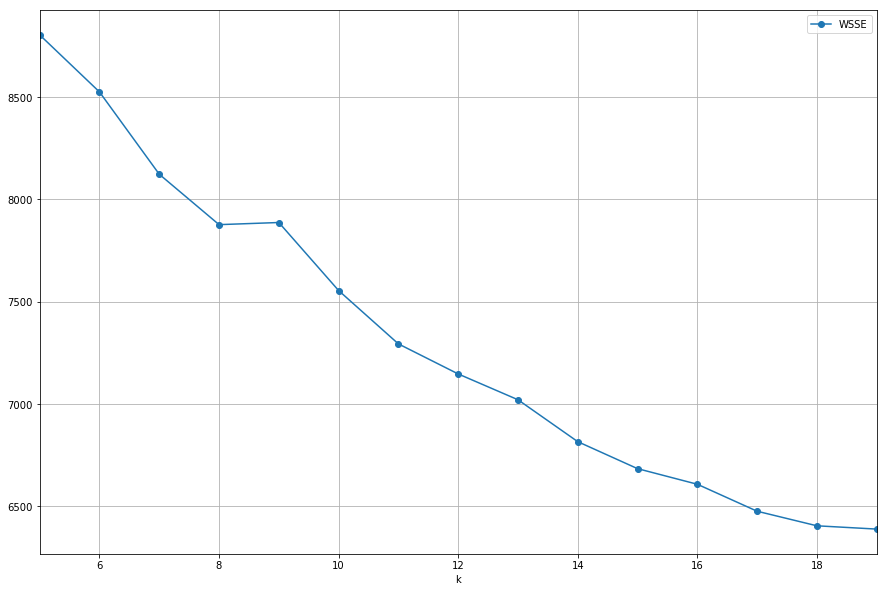

In [14]:
utils.elbow_plot(wsseList, clusters)

In [15]:
scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

DataFrame[features: vector]

In [16]:
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

In [17]:
centers = model.clusterCenters()
centers

[array([-0.14026518,  0.86444289, -1.29611604, -0.57549725, -1.15615086,
        -0.58794207, -0.65344221]),
 array([-1.13185142, -0.89009903,  0.44882161,  1.92393798,  0.54519871,
         1.88402914,  0.92758225]),
 array([ 1.1819048 , -0.25546635, -1.13923305,  2.14668077, -1.04253452,
         2.26466851, -1.13526669]),
 array([-0.23438971,  0.56939821,  0.21327809, -0.62471087,  0.38571009,
        -0.63632734, -0.38503172]),
 array([ 0.28619766,  0.80261237,  1.32726951, -0.64574267,  1.60304608,
        -0.60150071, -0.75538801]),
 array([-0.90208126, -1.14445222,  0.36398347,  0.23392991,  0.49349725,
         0.22455901,  1.33967193]),
 array([ 0.0042953 , -0.74014408, -1.17461278, -0.57772622, -1.0197678 ,
        -0.58959309,  0.85504144]),
 array([ 0.35816173, -0.9656737 ,  0.67897574, -0.50591352,  0.88734878,
        -0.49296518,  1.10682821]),
 array([ 1.42056664, -0.11914624, -1.11563163, -0.09513934, -0.9755258 ,
        -0.07601403, -0.97545474]),
 array([ 0.12811702

In [18]:
P = utils.pd_centers(featuresUsed, centers)

## Dry Days

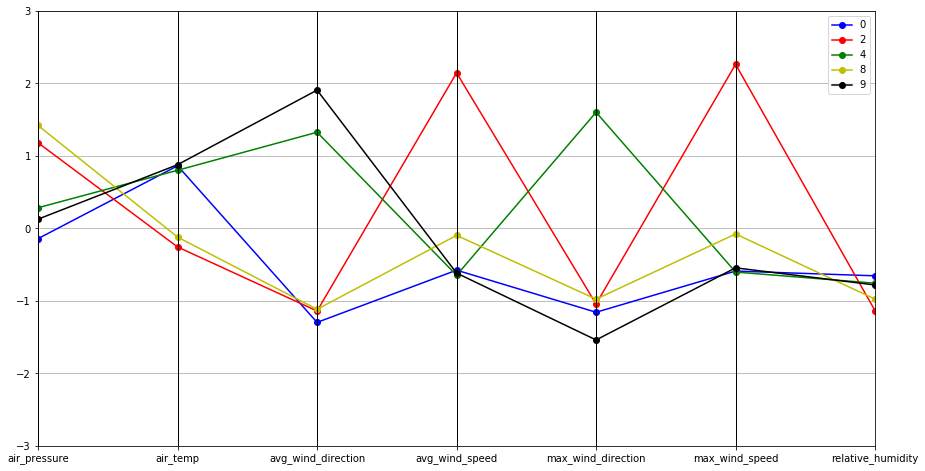

In [19]:
utils.parallel_plot(P[P['relative_humidity'] < -0.5], P)

## Warm Days

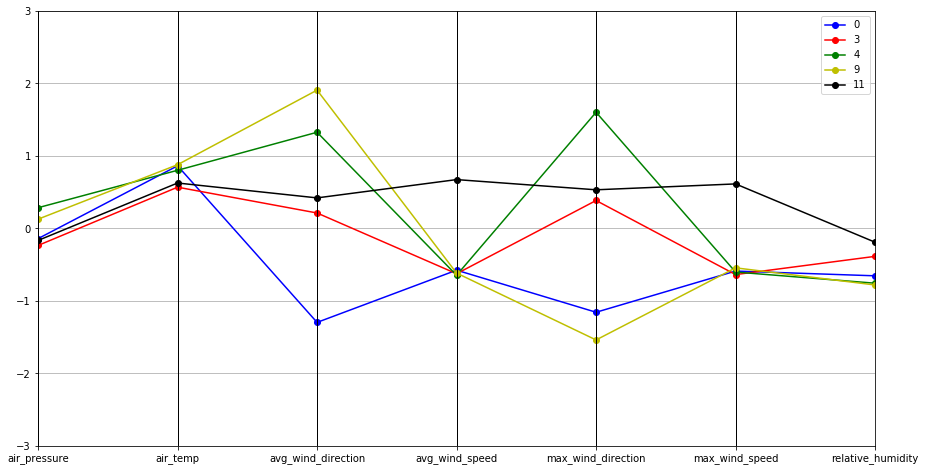

In [20]:
utils.parallel_plot(P[P['air_temp'] > 0.5], P)

## Cool Days

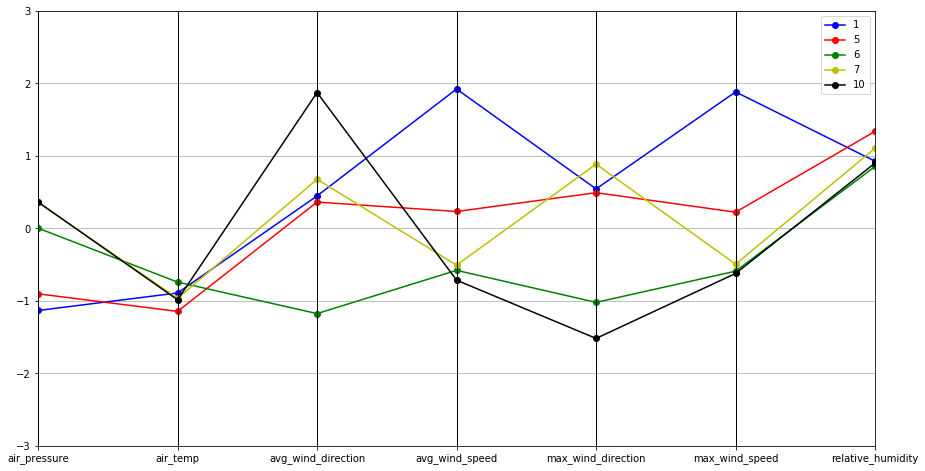

In [21]:
utils.parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)], P)

## Other Days

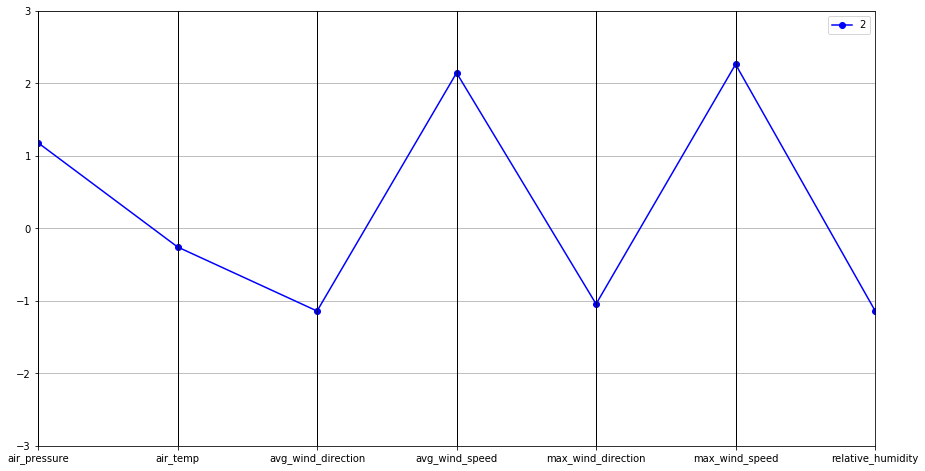

In [22]:
utils.parallel_plot(P.iloc[[2]], P)